# IDX Banking Stocks Forecast using Long Short-Term Memmory 2020-2023

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from datetime import date

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn

import os
import keras
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose, STL

os.environ["KERAS_BACKEND"] = "torch"

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")
    
torch.mps.set_per_process_memory_fraction(0.0)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

sns.set_theme(style="whitegrid")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
tensor([1.], device='mps:0')


## Load Dataset

In [2]:
# banking_stocks = ['BBCA']
banking_stocks = ['BBCA', 'BBNI', 'BBRI', 'BMRI']

stock_data = {}

for stock in banking_stocks: 
    data = pd.read_csv(f'data/{stock}_2023.csv', encoding='utf-8')
    data["Date"] = pd.to_datetime(data["Date"])
    
    stock_data[stock] = data

In [3]:
# stock_data['BBCA'].head()

In [4]:
# stock_data['BBCA'].info()

## Data Visualization

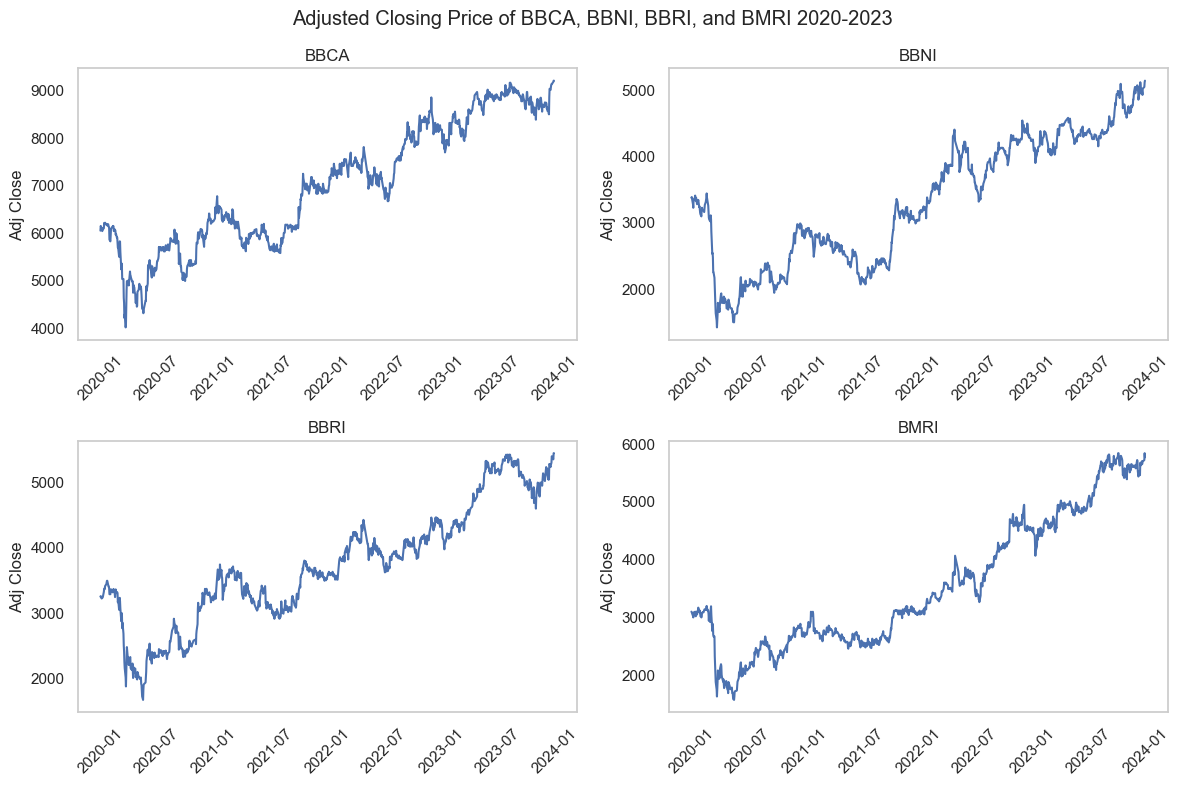

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

fig.suptitle("Adjusted Closing Price of BBCA, BBNI, BBRI, and BMRI 2020-2023")

for (stock, df), ax in zip(stock_data.items(), axes.ravel()):
    ax.plot("Date", "Adj Close", data=df)
    ax.set_title(stock)
    ax.grid(False)
    ax.set_ylabel("Adj Close")
    ax.tick_params(axis='x', rotation=45)
    
fig.tight_layout()
plt.show()

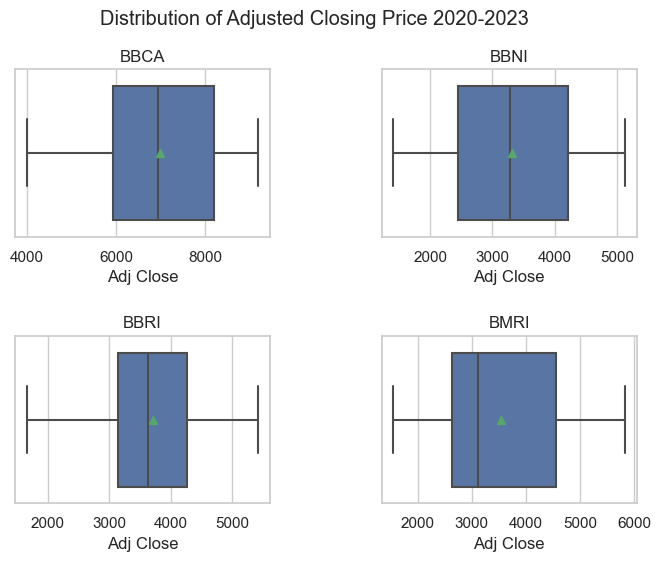

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.tight_layout(pad=4)

fig.suptitle("Distribution of Adjusted Closing Price 2020-2023")

for (stock, df), ax in zip(stock_data.items(), axes.ravel()):
    g = sns.boxplot(x="Adj Close", data=df, showmeans=True, ax=ax)
    g.set_title(stock, fontweight="normal")

plt.show()

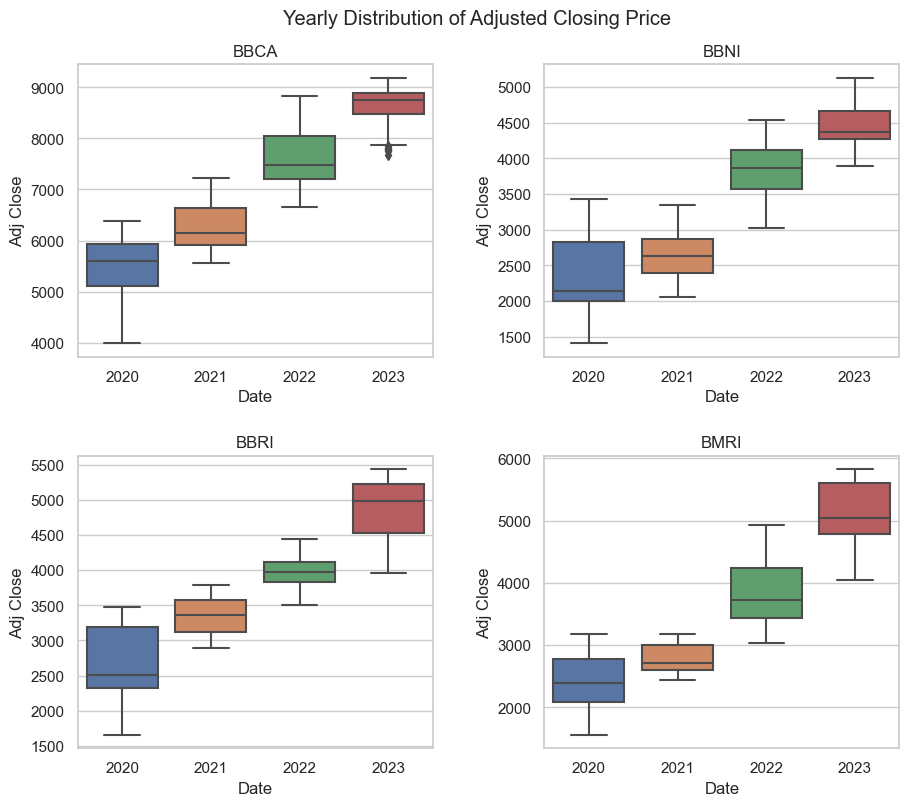

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8.5))
fig.tight_layout(pad=4)

fig.suptitle("Yearly Distribution of Adjusted Closing Price")

for (stock, df), ax in zip(stock_data.items(), axes.ravel()):
    g = sns.boxplot(x=df["Date"].dt.year, y=df["Adj Close"], data=df, ax=ax)
    g.set_title(stock, fontweight="normal")
    
plt.show()

## Time Series Component Decomposition

In [8]:
copy_stock_data = {}

for key, df in stock_data.items():
    new_df = df.copy()
    new_df.set_index('Date', inplace=True)
    copy_stock_data[key] = new_df
    
sns.set_theme(style="white")

In [9]:
def plot_decomposition(df, stock, col):
    advanced_decomposition = STL(df[col], period=4).fit()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)
    fig.suptitle(f"{stock} Decomposition")

    ax1.plot(advanced_decomposition.observed)
    ax1.set_ylabel('Observed')

    ax2.plot(advanced_decomposition.trend)
    ax2.set_ylabel('Trend')

    ax3.plot(advanced_decomposition.seasonal)
    ax3.set_ylabel('Seasonal')

    ax4.plot(advanced_decomposition.resid)
    ax4.set_ylabel('Residuals')

    fig.autofmt_xdate()
    plt.tight_layout()

### BBCA Decomposition

In [10]:
# plot_decomposition(copy_stock_data["BBCA"], "BBCA", "Adj Close")

### BBNI Decomposition

In [11]:
# plot_decomposition(copy_stock_data["BBNI"], "BBNI", "Adj Close")

### BBRI Decomposition

In [12]:
# plot_decomposition(copy_stock_data["BBRI"], "BBRI", "Adj Close")

### BMRI Decomposition

In [13]:
# plot_decomposition(copy_stock_data["BMRI"], "BMRI", "Adj Close")

## Preprocessing

In [14]:
def prepare_stock_data(df, train_size, col, scaler, time_step_train, time_step_test, batch_size):
    # Preprocessing
    train_size = int(len(df) * (train_size / 100))
    train_data, test_data = df[:train_size], df[train_size:]
    
    test_data.set_index('Date', inplace=True)
    test_data = test_data[[col]]
    
    dataset_train = train_data[col].values.reshape(-1, 1)
    dataset_test = test_data[col].values.reshape(-1, 1)
    # dataset_train = train_data[col].values[:, None]  
    # dataset_test = test_data[col].values[:, None]    
    
    scaled_train = scaler.fit_transform(dataset_train)
    scaled_test = scaler.fit_transform(dataset_test)
    
    # Create dataset
    def create_dataset(dataset, time_step):
        X, Y = [], []
        for i in range(len(dataset) - time_step):
            X.append(dataset[i:i+time_step])
            Y.append(dataset[i+1:i+time_step+1])
        return np.array(X), np.array(Y)
    
    X_train, y_train = create_dataset(scaled_train, time_step_train)
    X_test, y_test = create_dataset(scaled_test, time_step_test)
    
    X_train = torch.tensor(X_train).float().to(device)
    y_train = torch.tensor(y_train).float().to(device)
    X_test = torch.tensor(X_test).float().to(device)
    y_test = torch.tensor(y_test).float().to(device)
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'test_loader': test_loader,
        'test_data': test_data,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }

In [15]:
train_size = 80
scaler = MinMaxScaler()
time_step_train = 50
time_step_test = 30
batch_size = 8

In [16]:
stock_target = 'BBCA'

target_data = pd.read_csv(f'data/{stock_target}_2023.csv', encoding='utf-8')
target_data["Date"] = pd.to_datetime(target_data["Date"])

In [17]:
data_dict = {}

data_dict = prepare_stock_data(target_data, train_size, "Adj Close", scaler, time_step_train, time_step_test, batch_size)

In [18]:
# data_dict

## LSTM Modeling

In [19]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): 
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [20]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

num_epochs = 10
learning_rate = 1e-3

In [21]:
training_test_hist_dict = {}

def train_and_evaluate(stock, model, train_loader, test_loader, loss_fn, optimizer, num_epochs):
    
    train_hist = []
    test_hist = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)
     
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
     
            total_loss += loss.item()
        
        average_loss = total_loss / len(train_loader)
        train_hist.append(average_loss)
     
        model.eval()
        with torch.no_grad():
            total_test_loss = 0.0
     
            for batch_X_test, batch_y_test in test_loader:
                batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                predictions_test = model(batch_X_test)
                test_loss = loss_fn(predictions_test, batch_y_test)
     
                total_test_loss += test_loss.item()
        
            average_test_loss = total_test_loss / len(test_loader)
            test_hist.append(average_test_loss)
            
        if (epoch+1) % 10 == 0:
            print(f'Stock: {stock}, Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')
    
    training_test_hist_dict[stock] = {'train_hist': train_hist, 'test_hist': test_hist}
    
    model_path = f'models/{stock}_lstm_model.pth'
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')

In [22]:
loss_fn = torch.nn.MSELoss(reduction='mean')
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
train_and_evaluate(stock_target, model, data_dict['train_loader'], data_dict['test_loader'], loss_fn, optimizer, num_epochs)

Stock: BBCA, Epoch [10/50] - Training Loss: 0.0008, Test Loss: 0.0054
Stock: BBCA, Epoch [20/50] - Training Loss: 0.0005, Test Loss: 0.0047
Stock: BBCA, Epoch [30/50] - Training Loss: 0.0005, Test Loss: 0.0046
Stock: BBCA, Epoch [40/50] - Training Loss: 0.0006, Test Loss: 0.0045
Stock: BBCA, Epoch [50/50] - Training Loss: 0.0005, Test Loss: 0.0046
Model saved to models/BBCA_lstm_model.pth


## Training and Test Loss History

In [24]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# fig.suptitle("Training and Test Loss History")

# for (stock, hist_data), ax in zip(training_test_hist_dict.items(), axes.ravel()):
#     x = np.linspace(1, num_epochs, num_epochs)
#     ax.plot(x, hist_data['train_hist'], label="Training loss")
#     ax.plot(x, hist_data['test_hist'], label="Test loss")
#     ax.set_title(stock)
#     ax.set_xlabel('Epoch')
#     ax.set_ylabel('Loss')
#     ax.legend()

# plt.tight_layout()
# plt.show()

## Forecasting

In [25]:
# def predict(model, X_test, scaler):
#     predictions = []
    
#     with torch.no_grad():
#         X_test_tensor = torch.as_tensor(X_test, dtype=torch.float32).to(device)        
#         output = model(X_test)
#         predictions = scaler.inverse_transform(output.cpu().numpy().reshape(-1, 1))
        
#     return predictions

In [37]:
def forecast(model, X_test, test_data, scaler, num_forecast_steps=30):
    
    sequence_to_plot = X_test.squeeze().cpu().numpy()
    historical_data = sequence_to_plot[-1]
    print(historical_data.shape)

    forecasted_values = []

    with torch.no_grad():
        for _ in range(num_forecast_steps*2):
            historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
            predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

            forecasted_values.append(predicted_value[0])

            historical_data = np.roll(historical_data, shift=-1)
            historical_data[-1] = predicted_value.item()

    last_date = test_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
    combined_index = test_data.index.append(future_dates)
    combined_index
    return sequence_to_plot, forecasted_values, combined_index

In [38]:
seq, for_values, combined_index = forecast(model, data_dict['X_test'], data_dict['test_data'], scaler, 30)

(30,)


In [41]:
def plot_forecast(test_data, target, sequence_to_plot, forecasted_values, combined_index):
        
    plt.rcParams['figure.figsize'] = [14, 4] 

    plt.plot(test_data.index[-100:-30], target[-100:-30], label = "test_data", color = "b") 
    original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 

    plt.plot(test_data.index[-30:], original_cases, label='actual values', color='green') 

    forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
    plt.plot(combined_index[-60:], forecasted_cases, label='forecasted values', color='red')  

    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Time Series Forecasting')
    plt.grid(False)

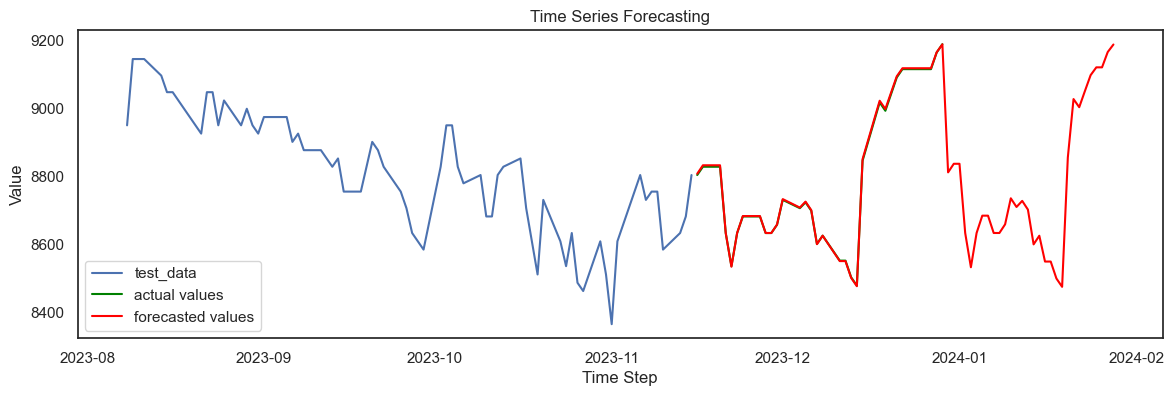

In [42]:
plot_forecast(data_dict['test_data'], data_dict['test_data']['Adj Close'], seq, for_values, combined_index)